In [ ]:
# sudo docker run -d --name opensearch-knn -p 9200:9200 -p 9600:9600 -e "discovery.type=single-node" -e "bootstrap.memory_lock=true" -e "OPENSEARCH_INITIAL_ADMIN_PASSWORD=a.Zerty12.3" --ulimit memlock=-1:-1 -v osdata:/usr/share/opensearch/data opensearchproject/opensearch:2.13.0

# Project Week 1: ActivityNet Video Data Preparation and Indexing

In this example we will use the ActivityNet dataset https://github.com/activitynet/ActivityNet.

 - Select the 10 videos with more moments.
 - Download these videos onto your computer.
 - Extract the frames for every video.
 - Read the textual descriptions of each video.
 - Index the video data in OpenSearch.

 In this week, you will index the video data and make it searchable with OpenSearch. You should refer to the OpenSearch tutorial laboratory.

## Select videos
Download the `activity_net.v1-3.min.json` file containing the list of videos. The file is in the github repository of ActivityNet.
Parse this file and select the 10 videos with more moments.

In [ ]:
#comment to execute locally
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#! ls drive/MyDrive/mpdw_project/

In [ ]:
#comment to execute locally
my_path = 'drive/MyDrive/mpdw_project/'

# #uncomment to execute locally
# my_path = './'

In [ ]:
! pip install yt-dlp

In [ ]:
import json
from pprint import pprint
import subprocess

with open(my_path + 'activity_net.v1-3.min.json', 'r') as json_data:
    data = json.load(json_data)
    video_annotations = [
    {
        "video_id": vid,
        "num_moments": len(details["annotations"]),
        "url": details["url"],
        "duration": details["duration"]
    }
    for vid, details in data["database"].items()
    ]
    top_videos = sorted(video_annotations, key=lambda x: x["num_moments"], reverse=True)[:11]

    print(top_videos)


[{'video_id': 'o1WPnnvs00I', 'num_moments': 23, 'url': 'https://www.youtube.com/watch?v=o1WPnnvs00I', 'duration': 229.86}, {'video_id': 'oGwn4NUeoy8', 'num_moments': 23, 'url': 'https://www.youtube.com/watch?v=oGwn4NUeoy8', 'duration': 153.09}, {'video_id': 'VEDRmPt_-Ms', 'num_moments': 20, 'url': 'https://www.youtube.com/watch?v=VEDRmPt_-Ms', 'duration': 232.07999999999998}, {'video_id': 'qF3EbR8y8go', 'num_moments': 19, 'url': 'https://www.youtube.com/watch?v=qF3EbR8y8go', 'duration': 204.1}, {'video_id': 'DLJqhYP-C0k', 'num_moments': 18, 'url': 'https://www.youtube.com/watch?v=DLJqhYP-C0k', 'duration': 186.968}, {'video_id': 't6f_O8a4sSg', 'num_moments': 18, 'url': 'https://www.youtube.com/watch?v=t6f_O8a4sSg', 'duration': 218.52}, {'video_id': '6gyD-Mte2ZM', 'num_moments': 18, 'url': 'https://www.youtube.com/watch?v=6gyD-Mte2ZM', 'duration': 188.245}, {'video_id': 'jBvGvVw3R-Q', 'num_moments': 18, 'url': 'https://www.youtube.com/watch?v=jBvGvVw3R-Q', 'duration': 218.62}, {'video_id

In [ ]:
import os
import subprocess

# Directory where videos will be saved
download_path = my_path +"videos"
os.makedirs(download_path, exist_ok=True)  # Create folder if it doesn't exist

# Loop through each video in the top 10
for elt in top_videos:
    output_template = os.path.join(download_path, f"{elt['video_id']}.mp4")

    try:
        print(f"Downloading: {elt['url']}")
        subprocess.run(["yt-dlp","-f", "best", "-o", output_template, elt['url']], check=True)
        print(f"Downloaded: {output_template}")
    except subprocess.CalledProcessError:
        print(f"Failed to download {elt['video_id']}.")

Downloading: https://www.youtube.com/watch?v=o1WPnnvs00I
Downloaded: drive/MyDrive/mpdw_project/videos/o1WPnnvs00I.mp4
Downloading: https://www.youtube.com/watch?v=oGwn4NUeoy8
Downloaded: drive/MyDrive/mpdw_project/videos/oGwn4NUeoy8.mp4
Downloading: https://www.youtube.com/watch?v=VEDRmPt_-Ms
Downloaded: drive/MyDrive/mpdw_project/videos/VEDRmPt_-Ms.mp4
Downloading: https://www.youtube.com/watch?v=qF3EbR8y8go
Downloaded: drive/MyDrive/mpdw_project/videos/qF3EbR8y8go.mp4
Downloading: https://www.youtube.com/watch?v=DLJqhYP-C0k
Downloaded: drive/MyDrive/mpdw_project/videos/DLJqhYP-C0k.mp4
Downloading: https://www.youtube.com/watch?v=t6f_O8a4sSg
Downloaded: drive/MyDrive/mpdw_project/videos/t6f_O8a4sSg.mp4
Downloading: https://www.youtube.com/watch?v=6gyD-Mte2ZM
Downloaded: drive/MyDrive/mpdw_project/videos/6gyD-Mte2ZM.mp4
Downloading: https://www.youtube.com/watch?v=jBvGvVw3R-Q
Downloaded: drive/MyDrive/mpdw_project/videos/jBvGvVw3R-Q.mp4
Downloading: https://www.youtube.com/watch?v=PJ7

In [ ]:
import json

caption_files = [
    my_path + 'captions_dataset/train.json',
    my_path + 'captions_dataset/val_1.json',
    my_path + 'captions_dataset/val_2.json'
]

captions_per_video = {}

# Parse the caption files and retrieve sentences and timestamps for each video
for file in caption_files:
    with open(file, 'r') as f:
        data = json.load(f)
        for video_id, video_data in data.items():
            if video_id not in captions_per_video:
                captions_per_video[video_id] = {
                    "sentences": [],
                    "timestamps": []
                }
            captions_per_video[video_id]["sentences"].extend(video_data.get("sentences", []))
            captions_per_video[video_id]["timestamps"].extend(video_data.get("timestamps", []))

# Now associate sentences and timestamps with each video
for video in top_videos:
    video_id = "v_" + video["video_id"]
    data = captions_per_video.get(video_id, {})
    sentences = data.get("sentences", [])
    timestamps = data.get("timestamps", [])

    moments = []
    if len(sentences) == len(timestamps):
        # Create multiple moments for the video
        for sentence, timestamp in zip(sentences, timestamps):
            start = timestamp[0]
            end = timestamp[1]
            moment = {
                "start": start,
                "end": end,
                "description": sentence,
                "bow": list(set(sentence.lower().split()))  # Bag of words
            }
            moments.append(moment)  # Append the moment for each sentence
    else:
        print(f"Warning: Mismatch for {video_id} — {len(sentences)} sentences vs {len(timestamps)} timestamps")
    #print(moments)
    # Update the video with the list of moments
    video["moments"] = moments
    #print(f"Video {video_id} has {len(moments)} moments.")

## Video frame extraction

PyAV is a wrapper library providing you access to `ffmpeg`, a command-line video processing tool. In the example below, you will be able to extract frames from the a video shot.

In [ ]:
! pip install av

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 24.8 MB/s eta 0:00:00


In [ ]:
import av
import av.datasets
import os

video_folder = my_path + "videos"
output_folder = my_path + "frames"

for video in os.listdir(video_folder):
    # File name without extension
    filename = os.path.splitext(video)[0]
    if not os.path.isdir(output_folder + "/" + filename):
        os.makedirs(output_folder + "/" + filename)
    with av.open(video_folder + "/" + video) as container:
        stream = container.streams.video[0]
        # We want 1 frame per second
        fps = stream.average_rate
        interval = int(fps)
        #print(fps)
        cpt = 0
        #for i,frame in enumerate(container.decode(stream)):
            #if i % interval == 0:
                #frame.to_image().save(output_folder+"/"+filename+"/"+str(cpt)+".jpg", quality=80)
                #cpt += 1

## Video metadata

Process the video metadata provided in the `json` file and index the video data in OpenSearch.

In [ ]:
! pip install opensearch-py

In [ ]:
# Connect to OpenSearch and then create the index if it doesn't exist yet

from opensearchpy import OpenSearch
import pprint as pp


host = 'localhost'
port = 9200

user = 'admin' # Add your user name here.
password = 'a.Zerty12.3' # Add your user password here. For testing only. Don't store credentials in code.
index_name = user

client = OpenSearch(
    hosts = [{'host': host, 'port': port}],
    http_auth = (user, password),
    use_ssl = True,
    verify_certs = False,
)

index_body = {
   "settings":{
      "index":{
         "number_of_replicas":0,
         "number_of_shards":4,
         "refresh_interval":"-1",
         "knn":"true"
      }
   },
  "mappings": {
    "properties": {
      "vid_id": {
        "type": "keyword"
      },
      "moment_description": {
        "type": "text",
        "analyzer": "standard"
      },
      "start_timestamp": {
        "type": "float"
      },
      "end_timestamp": {
        "type": "float"
      },
      "video_length": {
        "type": "float"
      },
      "caption_bow": {
        "type": "text",
        "analyzer": "standard"
      }
      # "caption_vec": { #implemented after
      #   "type": "knn_vector",
      #   "dimension": 384, #Depend on the embedding model
      #   "index": True,
      #   "similarity": "cosine"
      # },
      # "keyframe_vec": {
      #   "type": "knn_vector",
      #   "dimension": 768,
      #   "index": True,
      #   "similarity": "cosine"
      # },
    }
  }
}

if client.indices.exists(index=index_name):
    print("Index already existed. Nothing to be done.")
else:
    response = client.indices.create(index_name, body=index_body)
    print('\nCreating index:')
    print(response)

/usr/local/lib/python3.11/dist-packages/opensearchpy/connection/http_urllib3.py:214: UserWarning: Connecting to https://localhost:9200 using SSL with verify_certs=False is insecure.
  warnings.warn(
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/opensearchpy/connection/http_urllib3.py", line 280, in perform_request
    response = self.pool.urlopen(
               ^^^^^^^^^^^

ConnectionError: ConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f75904bd0>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f75904bd0>: Failed to establish a new connection: [Errno 111] Connection refused)

In [ ]:
#Index every moments on OpenSearch (only do it once per index, if else it will make copies)
for video in top_videos:
        video_id = video['video_id']
        for moment in video['moments']:
            #print("Nb moments: ",len(video['moments']))
            document = {
                "vid_id": video_id,
                "start_timestamp": moment["start"],
                "end_timestamp": moment["end"],
                "video_length": video["duration"],
                "caption_bow": moment["bow"],
                #"caption_vec": moment["caption_vec"][0],  # This should be a list of floats (embedding)
                "moment_description": moment["description"]
            }
            # Index the document in OpenSearch
            response = client.index(index=index_name, body=document)
            #print(response)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/opensearchpy/connection/http_urllib3.py", line 280, in perform_request
    response = self.pool.urlopen(
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 841, in urlopen
    retries = retries.increment(
              ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/pytho

ConnectionError: ConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f75fe2b90>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f75fe2b90>: Failed to establish a new connection: [Errno 111] Connection refused)

In [ ]:
# Give every documents added to the index
client.indices.refresh(index=index_name)
query = {
    "query": {
        "match_all": {}
    },
    "size": 100  # Adjust the number to see more results if needed
}

response = client.search(
    index=index_name,
    body=query
)

# Print the total number of documents and some of the documents
print(f"Total hits: {response['hits']['total']['value']}")
for hit in response['hits']['hits']:
    print(hit['_source'])  # Print the source of each document

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/opensearchpy/connection/http_urllib3.py", line 280, in perform_request
    response = self.pool.urlopen(
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 841, in urlopen
    retries = retries.increment(
              ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/pytho

ConnectionError: ConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f7596d4d0>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f7596d4d0>: Failed to establish a new connection: [Errno 111] Connection refused)

In [ ]:
# Search based on words in the description
client.indices.refresh(index=index_name)
query = {
    "query": {
        "match": {
            "moment_description":{
                "query": "man",
                "operator": "and"
            }
        }
    },
    "size":100
}

response = client.search(
    index=index_name,
    body=query
)

# Print the total number of documents and some of the documents
print(f"Total hits: {response['hits']['total']['value']}")
for hit in response['hits']['hits']:
    print(hit['_source'])  # Print the source of each document

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/opensearchpy/connection/http_urllib3.py", line 280, in perform_request
    response = self.pool.urlopen(
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 841, in urlopen
    retries = retries.increment(
              ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/pytho

ConnectionError: ConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f7597ce10>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f7597ce10>: Failed to establish a new connection: [Errno 111] Connection refused)

## Embeddings Neighborhood

In [ ]:
# Compute the caption_vectors

from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take average of all tokens
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


#Encode text
def encode(texts):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)

    return embeddings


# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")


# Load the model on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Encode sentences
for video in top_videos:
    moments = video['moments']
    for moment in moments:
        caption = [moment["description"] for moment in moments]
        caption_vector = encode(caption)
        moment["caption_vec"] = caption_vector.tolist()

        #print(moment["caption_vec"])


In [ ]:
# Process each document and add embeddings and save to a JSON file
query = {
    "query": {
        "match_all": {}
    }
}

# Retrieve all documents from the index
response = client.search(index=index_name, body=query, size=1000)
documents = response["hits"]["hits"]

# Update each document with the new caption_vec field
for document in documents:
    caption = document["_source"]["moment_description"]  # Get the caption from the document
    caption_vector = encode([caption])  # Generate embedding for the caption
    document["caption_vec"] = caption_vector.tolist()[0]  # Convert tensor to list


# Save the documents to a JSON file
output_file = "documents_with_embeddings.json"
with open(output_file, "w") as f:
    json.dump(documents, f, indent=4)

print(f"Documents with embeddings have been saved to {output_file}")

In [ ]:
#check the number of elements in the file to see if it worked
import json

# Load the JSON file
file_path = "documents_with_embeddings.json"

with open(file_path, "r") as json_file:
    data = json.load(json_file)

# count the number of elements with the "id" field
count = sum(1 for item in data if "_id" in item)

print(f"Number of element : {count}")

In [ ]:
#revision of the index mapping
# New mapping for caption_vec
new_field_mapping = {
    "properties": {
        "caption_vec": {
            "type": "knn_vector",
            "dimension": 384,  # depend on the embedding model
            "index": True,
            "similarity": "cosine"
        }
    }
}

# Update the index mapping
response = client.indices.put_mapping(
    index=index_name,  # index name
    body=new_field_mapping
)

In [ ]:
#add the embeddings to the index
# Update the documents with caption_vec
query = {
    "query": {
        "match_all": {}
    }
}

# Retrieve all documents from the index
response = client.search(index=index_name, body=query, size=1000)
documents = response["hits"]["hits"]

# Update each document with the new caption_vec field
for doc in documents:
    doc_id = doc["_id"]  # ID document

    caption = doc["_source"]["moment_description"]  # Get the caption from the document
    caption_vector = encode([caption])  # Generate embedding for the caption
    embedding = caption_vector.tolist()[0]  # Convert tensor to list
    print(embedding)

    # Update the document with the new field
    update_body = {
        "doc": {
            "caption_vec": embedding
        }
    }
    update_response = client.update(index=index_name, id=doc_id, body=update_body)


In [ ]:
# Refresh the index to make the changes visible
client.indices.refresh(index=index_name)
query = {
    "query": {
        "match_all": {}
    },
    "size": 100  # Adjust the number to see more results if needed
}

response = client.search(
    index=index_name,
    body=query
)

# Print the total number of documents and some of the documents
print(f"Total hits: {response['hits']['total']['value']}")
for hit in response['hits']['hits']:
    print(hit['_source'])  # Print the source of each document                "moment_description": moment["description"]

In [ ]:
# Search based on words in the description
client.indices.refresh(index=index_name)
query = {
    "query": {
        "match": {
            "moment_description":{
                "query": "man",
                "operator": "and"
            }
        }
    },
    "size":100
}

response = client.search(
    index=index_name,
    body=query
)

# Print the total number of documents and some of the documents
print(f"Total hits: {response['hits']['total']['value']}")
for hit in response['hits']['hits']:
    print(hit['_source'])  # Print the source of each document

In [ ]:
# test the search functionality
client.indices.refresh(index=index_name)
query1 = "a woman is playing guitar"
def test_embedding_neighbor_search(query):
    # Encode the query
    query_emb = encode([query])
    query = {
        "query": {
            "knn": {
                "caption_vec":{
                    "vector": query_emb[0].numpy(),
                    "k": 1
                }
            }
        },
        "size":1
    }

    response = client.search(
        index=index_name,
        body=query
    )

    print('\nThe closest result is:')
    pp.pprint(response['hits']['hits'][0]['_source']['moment_description'])  # Print the source of each document
    print('\nThe video ID is:')
    pp.pprint(response['hits']['hits'][0]['_source']['vid_id'])  # Print the source of each document
    print('\nThe score is:')
    pp.pprint(response['hits']['hits'][0]['_score'])  # Print the source of each document

test_embedding_neighbor_search(query1)

In [ ]:
#we can test it with different queries
queries = [
    "A person playing guitar",
    "A dog running in the park",
    "A group of people in a meeting",
    "A sunset over the ocean"
]

for elt in queries:
    print("\n\n")
    print(elt)
    test_embedding_neighbor_search(elt)

## Constrained Embedding Searches

In [ ]:
! pip install bertviz

In [ ]:
! pip install opensearch-py

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import AutoModel, AutoConfig, AutoTokenizer
from bertviz import head_view, model_view
from sentence_transformers import SentenceTransformer
from opensearchpy import OpenSearch

In [ ]:
host = 'localhost'
port = 9200
user = 'admin'
password = 'a.Zerty12.3'
index_name = 'admin'

client = OpenSearch(
    hosts=[{'host': host, 'port': port}],
    http_auth=(user, password),
    use_ssl=True,
    verify_certs=False,
)

# Instanciate a SentenceTransformer model (for embeddings research)
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
def text_search(query_text):
    """
    Simple request on 'moment_description' field.
    """
    body = {
        "query": {
            "match": {
                "moment_description": query_text
            }
        },
        "size": 10
    }
    response = client.search(index=index_name, body=body)
    return response

In [ ]:
def knn_search(query_text, k=5):
    """
    k-NN search on 'caption_vec' field.
    """
    query_embedding = model.encode([query_text])[0].tolist()
    body = {
        "size": k,
        "query": {
            "knn": {
                "caption_vec": {
                    "vector": query_embedding,
                    "k": k
                }
            }
        }
    }
    response = client.search(index=index_name, body=body)
    return response

In [ ]:
def text_with_boolean_filter(query_text, min_duration=0, max_duration=100000):
    """
    Text search + Boolean filter on video duration.
    """
    body = {
        "query": {
            "bool": {
                "must": [
                    {
                        "match": {
                            "moment_description": query_text
                        }
                    }
                ],
                "filter": [
                    {
                        "range": {
                            "video_length": {
                                "gte": min_duration,
                                "lte": max_duration
                            }
                        }
                    }
                ]
            }
        },
        "size": 10
    }
    response = client.search(index=index_name, body=body)
    return response

In [ ]:
def knn_with_boolean_filter(query_text, min_duration=0, max_duration=100000, k=5):
    """
    Search k-NN embeddings + boolean filter on video duration.
    """
    query_embedding = model.encode([query_text])[0].tolist()
    body = {
        "size": k,
        "query": {
            "bool": {
                "must": [
                    {
                        "knn": {
                            "caption_vec": {
                                "vector": query_embedding,
                                "k": k
                            }
                        }
                    }
                ],
                "filter": [
                    {
                        "range": {
                            "video_length": {
                                "gte": min_duration,
                                "lte": max_duration
                            }
                        }
                    }
                ]
            }
        }
    }
    response = client.search(index=index_name, body=body)
    return response

In [ ]:
print("=== Simple text search ===")
resp_text = text_search("dog playing in water")
print(resp_text)

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/opensearchpy/connection/http_urllib3.py", line 280, in perform_request
    response = self.pool.urlopen(
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 841, in urlopen
    retries = retries.increment(
              ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/pytho

=== Simple text search ===


ConnectionError: ConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f74d87810>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f74d87810>: Failed to establish a new connection: [Errno 111] Connection refused)

In [ ]:
print("\n=== Vectorial search (k-NN) ===")
resp_knn = knn_search("someone is playing guitar", k=3)
print(resp_knn)

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/opensearchpy/connection/http_urllib3.py", line 280, in perform_request
    response = self.pool.urlopen(
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 841, in urlopen
    retries = retries.increment(
              ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/pytho


=== Vectorial search (k-NN) ===


ConnectionError: ConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f74d86350>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f74d86350>: Failed to establish a new connection: [Errno 111] Connection refused)

In [ ]:
print("\n=== Filters + text ===")
resp_filt = text_with_boolean_filter("football match", min_duration=60, max_duration=300)
print(resp_filt)

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/opensearchpy/connection/http_urllib3.py", line 280, in perform_request
    response = self.pool.urlopen(
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 841, in urlopen
    retries = retries.increment(
              ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/pytho


=== Filters + text ===


ConnectionError: ConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f74cebb90>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f74cebb90>: Failed to establish a new connection: [Errno 111] Connection refused)

In [ ]:
print("\n=== Filters + vectorial ===")
resp_knn_filt = knn_with_boolean_filter("swimming pool", min_duration=100, max_duration=600, k=5)
print(resp_knn_filt)

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/opensearchpy/connection/http_urllib3.py", line 280, in perform_request
    response = self.pool.urlopen(
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 841, in urlopen
    retries = retries.increment(
              ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/pytho


=== Filters + vectorial ===


ConnectionError: ConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f74d76850>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPSConnection object at 0x7a1f74d76850>: Failed to establish a new connection: [Errno 111] Connection refused)

## Contextual Embeddings and Self-Attention

In [ ]:
def visualize_contextual_embeddings(model_name, sentence, layers_to_inspect=range(12)):
    """
    Visualizes contextual word embeddings from layer 0 to layer 11 (or a custom range).
    It uses PCA to project the embeddings to 2D. You can observe how the embeddings
    evolve from lower layers (layer 0) to higher layers (layer 11).
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
    model = AutoModel.from_pretrained(model_name, config=config)

    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    # hidden_states is a tuple: hidden_states[layer] -> (batch_size, seq_len, hidden_dim)
    hidden_states = outputs.hidden_states
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    plt.figure(figsize=(14, 10))
    for idx, layer_id in enumerate(layers_to_inspect):
        layer_emb = hidden_states[layer_id][0].detach().numpy()
        pca_emb = PCA(n_components=2).fit_transform(layer_emb)

        plt.subplot(3, 4, idx + 1)
        plt.scatter(pca_emb[:, 0], pca_emb[:, 1], c='blue')
        for i, token in enumerate(tokens):
            plt.text(pca_emb[i, 0] + 0.01, pca_emb[i, 1] + 0.01, token, fontsize=8)
        plt.title(f"Layer {layer_id}")
    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_positional_embeddings(model_name, repeated_word="hello", num_tokens=20, layer_id=0):
    """
    Feeds a sequence of the same token repeated num_tokens times, then visualizes
    the embeddings or distances across these tokens in a given layer.

    The idea is to see how positional encoding differentiates tokens that are
    otherwise identical in text but occur in different positions.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
    model = AutoModel.from_pretrained(model_name, config=config)

    sentence = " ".join([repeated_word] * num_tokens)
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    hidden_states = outputs.hidden_states
    all_tokens_emb = hidden_states[layer_id][0].detach().numpy()

    # Compute a distance matrix of shape [num_tokens, num_tokens]
    dist_matrix = np.zeros((num_tokens, num_tokens))
    for i in range(num_tokens):
        for j in range(num_tokens):
            dist_matrix[i, j] = np.linalg.norm(all_tokens_emb[i] - all_tokens_emb[j])

    plt.figure(figsize=(8, 6))
    plt.title(f"Distance Matrix for Layer {layer_id} - '{repeated_word}' repeated {num_tokens} times")
    plt.imshow(dist_matrix, cmap='viridis')
    plt.colorbar(label="Euclidean Distance")
    plt.xlabel("Token Index")
    plt.ylabel("Token Index")
    plt.show()

In [ ]:
def compare_self_attention(model_name_cross, model_name_dual, text_a, text_b):
    """
    Compares the self-attention patterns for a cross-encoder (text_a and text_b
    in the same input with a [SEP] token) vs. a dual-encoder (each text processed
    separately). Visualizes them via bertviz head_view.
    """
    # -- Cross-Encoder --
    tokenizer_cross = AutoTokenizer.from_pretrained(model_name_cross)
    config_cross = AutoConfig.from_pretrained(model_name_cross, output_hidden_states=True, output_attentions=True)
    model_cross = AutoModel.from_pretrained(model_name_cross, config=config_cross)

    inputs_cross = tokenizer_cross.encode_plus(
        text_a,
        text_b,
        return_tensors='pt',
        add_special_tokens=True,
        max_length=512,
        truncation=True
    )
    with torch.no_grad():
        outputs_cross = model_cross(**inputs_cross)

    attentions_cross = outputs_cross.attentions
    tokens_cross = tokenizer_cross.convert_ids_to_tokens(inputs_cross["input_ids"][0])

    print("\n=== CROSS-ENCODER ATTENTION (head_view) ===")
    head_view(attentions_cross, tokens_cross)

    # -- Dual-Encoder --
    tokenizer_dual = AutoTokenizer.from_pretrained(model_name_dual)
    config_dual = AutoConfig.from_pretrained(model_name_dual, output_hidden_states=True, output_attentions=True)
    model_dual = AutoModel.from_pretrained(model_name_dual, config=config_dual)

    inputs_dual_a = tokenizer_dual.encode_plus(text_a, return_tensors='pt', add_special_tokens=True)
    inputs_dual_b = tokenizer_dual.encode_plus(text_b, return_tensors='pt', add_special_tokens=True)

    with torch.no_grad():
        outputs_dual_a = model_dual(**inputs_dual_a)
        outputs_dual_b = model_dual(**inputs_dual_b)

    tokens_dual_a = tokenizer_dual.convert_ids_to_tokens(inputs_dual_a["input_ids"][0])
    tokens_dual_b = tokenizer_dual.convert_ids_to_tokens(inputs_dual_b["input_ids"][0])

    print("\n=== DUAL-ENCODER ATTENTION (text_a) ===")
    head_view(outputs_dual_a.attentions, tokens_dual_a)

    print("\n=== DUAL-ENCODER ATTENTION (text_b) ===")
    head_view(outputs_dual_b.attentions, tokens_dual_b)

In [ ]:
def interpretability_attention(model_name, text_a, text_b):
    """
    Visualizes how tokens attend to each other across layers, exploring how
    attention might relate to the model's final outputs. The function uses
    model_view from bertviz for an all-layer perspective.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)
    model = AutoModel.from_pretrained(model_name, config=config)

    inputs = tokenizer.encode_plus(text_a, text_b, return_tensors='pt', add_special_tokens=True)
    with torch.no_grad():
        outputs = model(**inputs)

    attentions = outputs.attentions
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    print("\n=== MODEL VIEW ATTENTION ===")
    model_view(attentions, tokens)

In [ ]:
def visualize_full_self_attention(model_name, text_a, text_b):
    """
    Creates a grid of subplots (layers x heads) to plot the entire self-attention
    matrix per head in each layer. This helps you inspect every attention map
    statically in one figure. Optionally uses bertviz for interactive analysis.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(model_name, output_attentions=True)
    model = AutoModel.from_pretrained(model_name, config=config)

    inputs = tokenizer.encode_plus(
        text_a,
        text_b,
        return_tensors='pt',
        add_special_tokens=True,
        max_length=512,
        truncation=True
    )
    with torch.no_grad():
        outputs = model(**inputs)

    attentions = outputs.attentions
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    num_layers = len(attentions)
    num_heads = attentions[0].shape[1]

    fig, axes = plt.subplots(nrows=num_layers, ncols=num_heads, figsize=(3 * num_heads, 3 * num_layers))
    fig.suptitle("Self-Attention Matrices for All Layers & Heads", fontsize=16)

    for layer_i in range(num_layers):
        for head_j in range(num_heads):
            ax = axes[layer_i, head_j] if num_layers > 1 else axes[head_j]
            attention_matrix = attentions[layer_i][0, head_j].detach().numpy()
            im = ax.imshow(attention_matrix, cmap='viridis')
            ax.set_title(f"Layer {layer_i}, Head {head_j}")
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()
    # head_view(attentions, tokens)

### Contextual embeddings

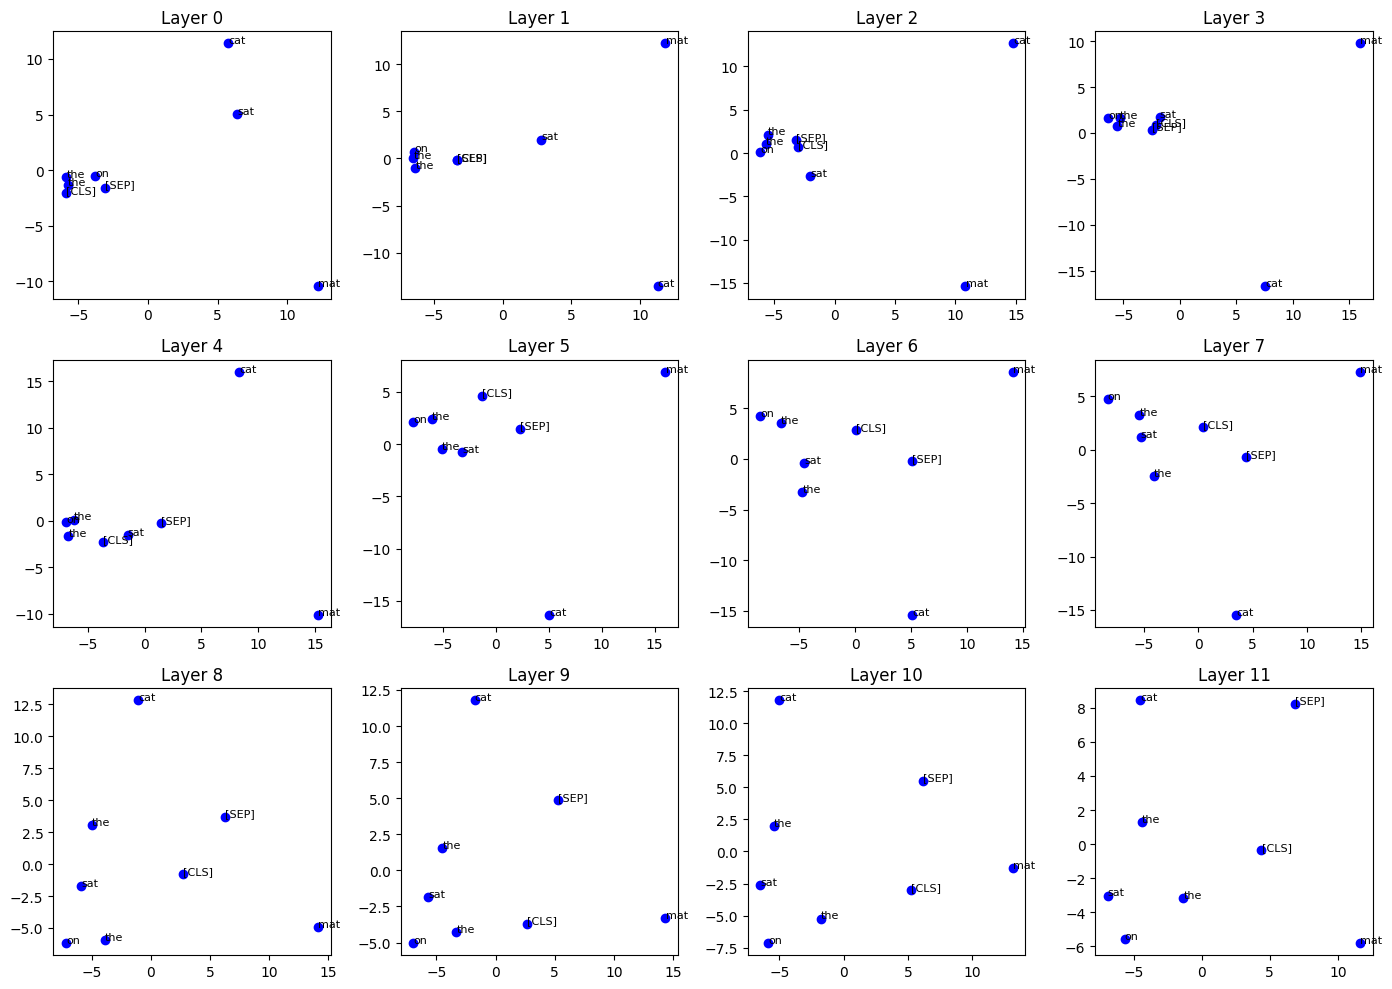

In [ ]:
example_sentence = "The cat sat on the mat"
visualize_contextual_embeddings(
    model_name="bert-base-uncased",
    sentence=example_sentence,
    layers_to_inspect=range(12)  # 0..11
)

### Positional embeddings

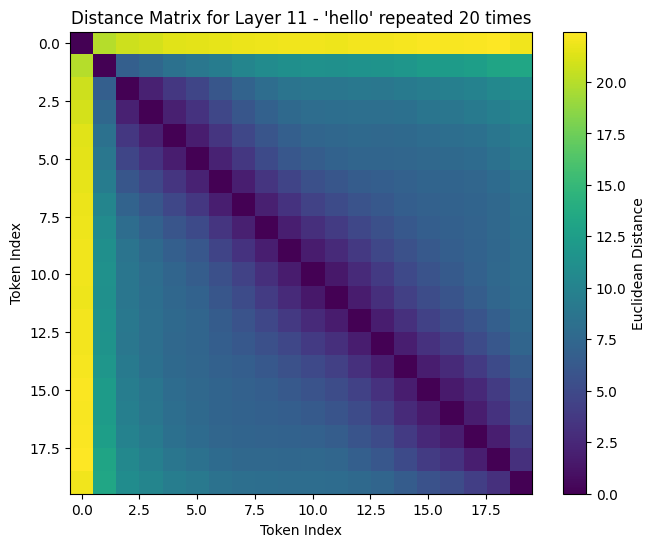

In [ ]:
visualize_positional_embeddings(
    model_name="bert-base-uncased",
    repeated_word="hello",
    num_tokens=20,
    layer_id=11  # try different layers
)

### Cross-encoder vs dual-encoder self-attention

In [ ]:
text_a = "How many people live in Berlin?"
text_b = "Berlin has around three and a half million inhabitants."
compare_self_attention(
    model_name_cross="bert-base-uncased",
    model_name_dual="sentence-transformers/all-MiniLM-L6-v2",
    text_a=text_a,
    text_b=text_b
)

Output hidden; open in https://colab.research.google.com to view.

### Interpretability

In [ ]:
interpretability_attention(
    model_name="bert-base-uncased",
    text_a="What is the capital of Germany?",
    text_b="Berlin is the capital of Germany."
)


=== MODEL VIEW ATTENTION ===


<IPython.core.display.Javascript object>

Full self-attention visualization

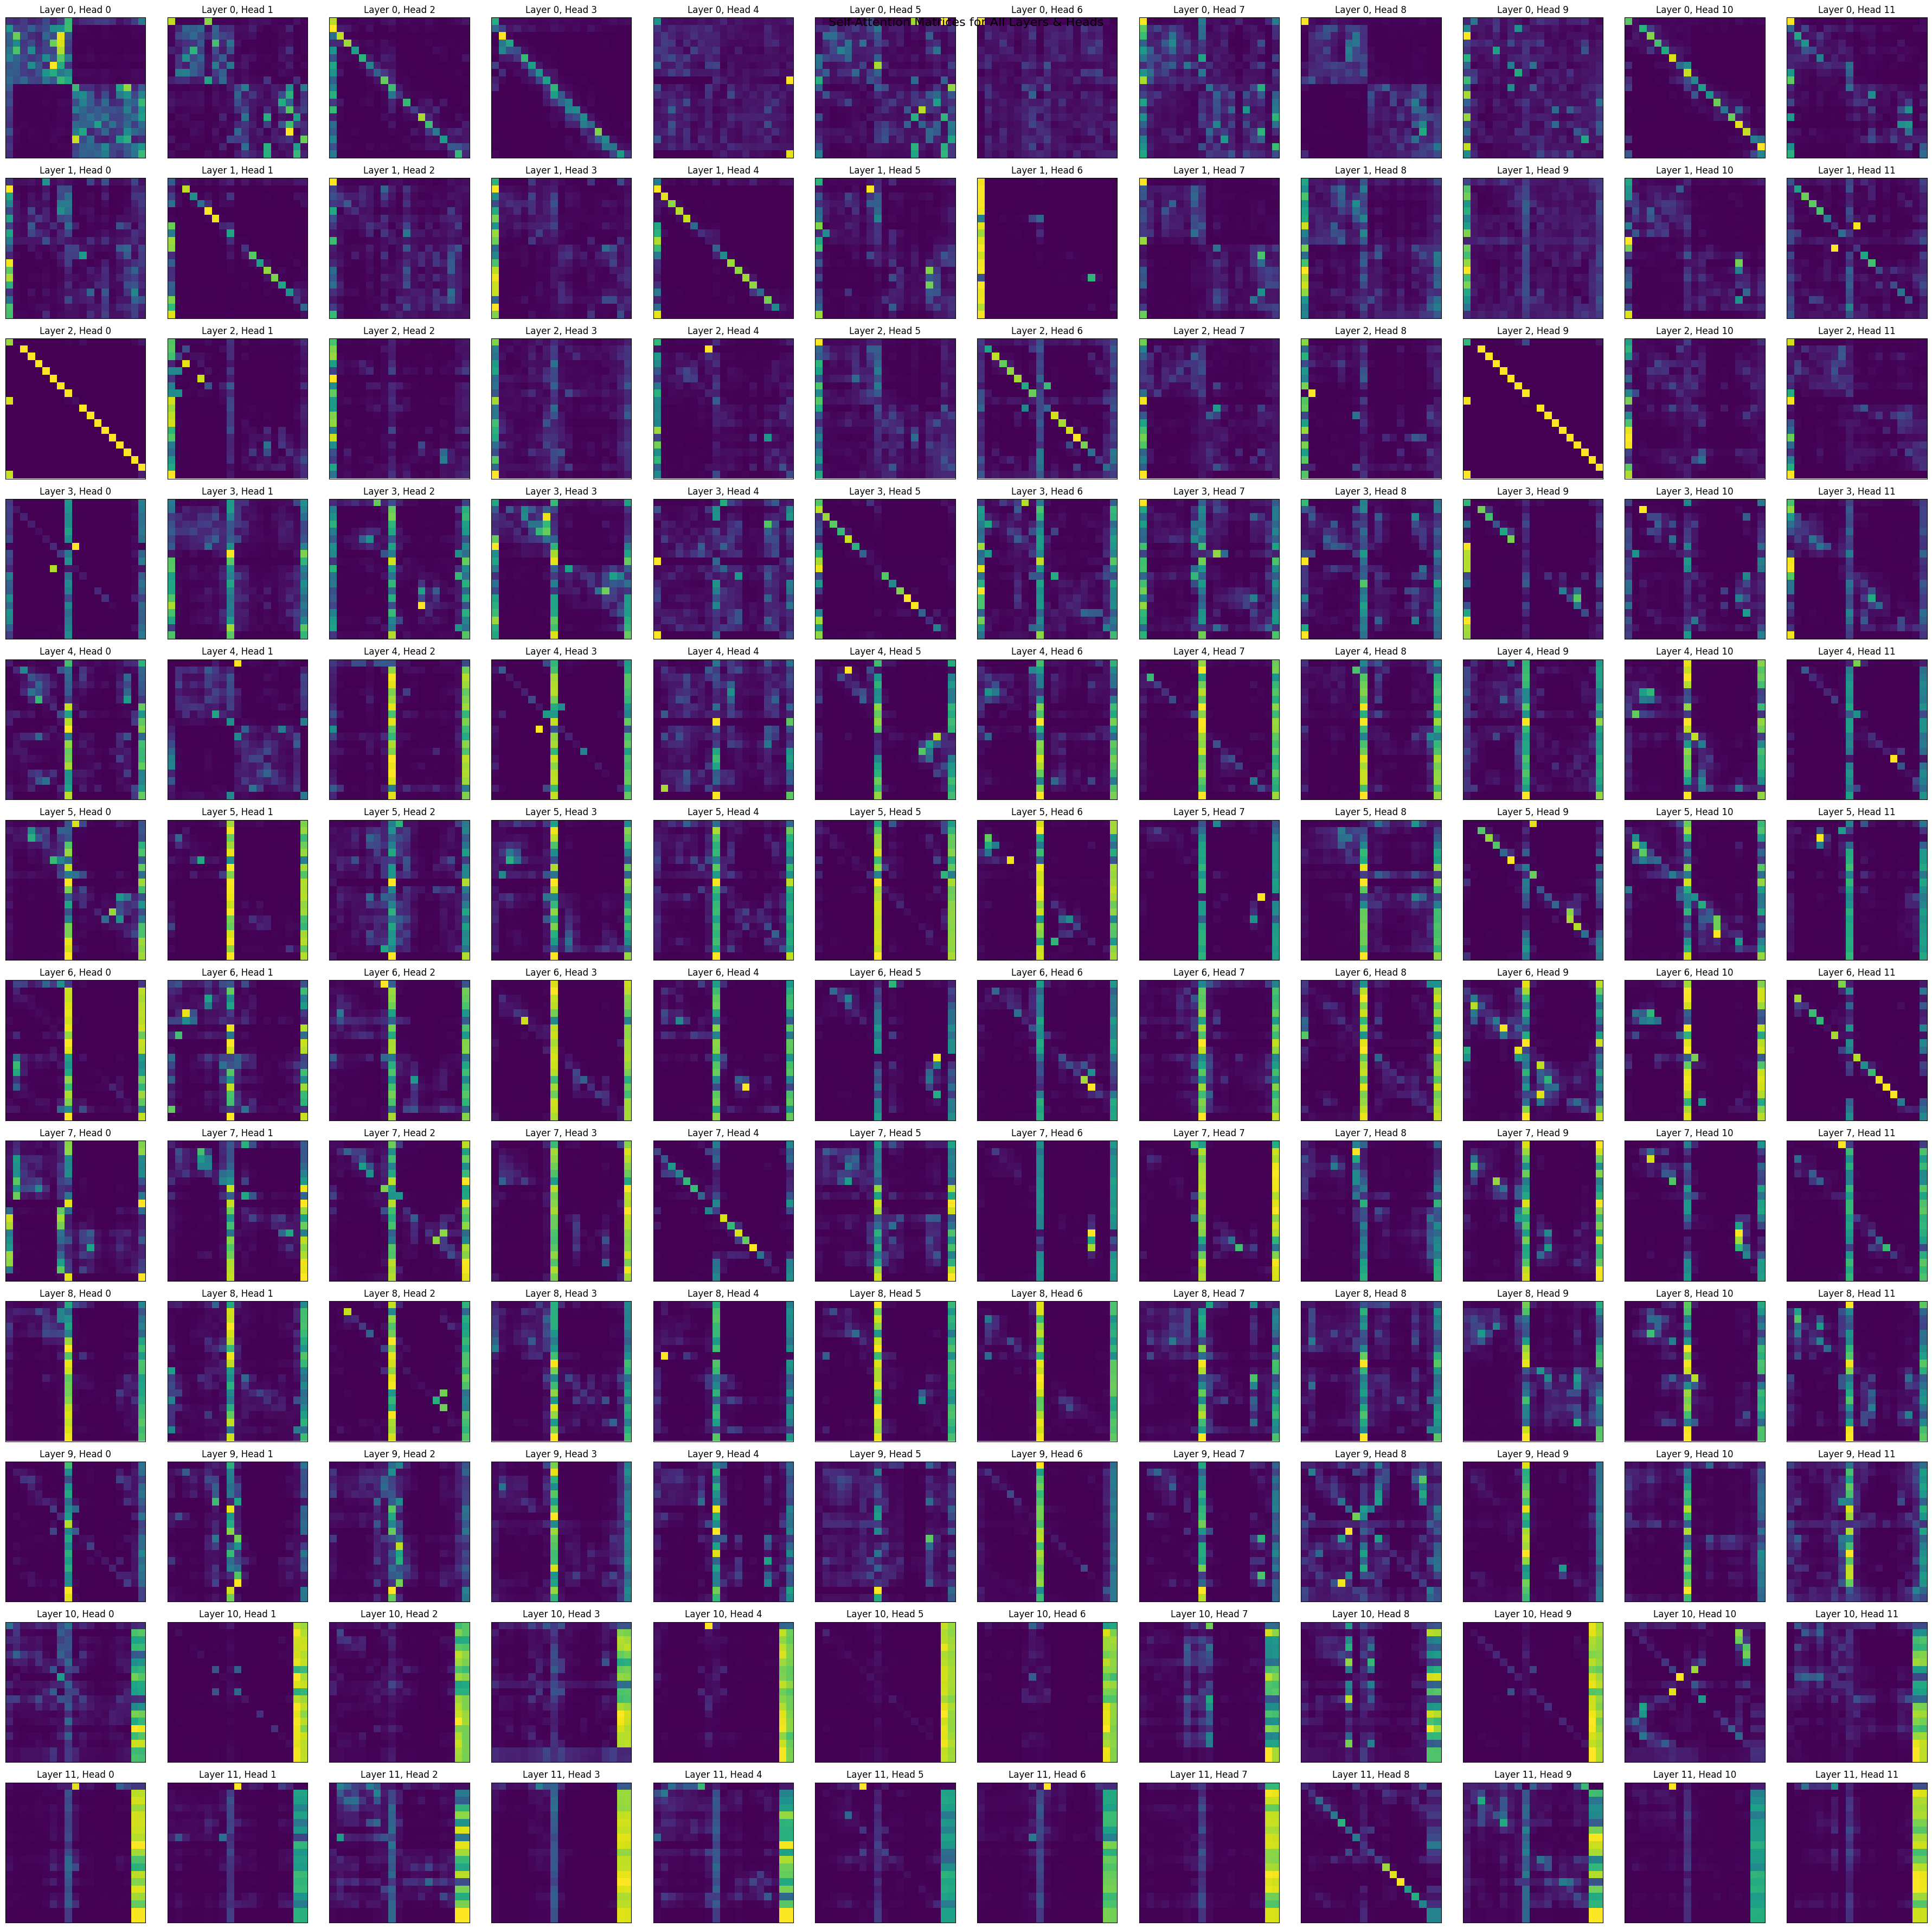

In [ ]:
visualize_full_self_attention(
    model_name="bert-base-uncased",
    text_a="How many people live in Berlin?",
    text_b="Berlin has around 3.7 million inhabitants."
)